In [1]:
!wget --header="Host: archive.ics.uci.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.101 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://archive.ics.uci.edu/ml/machine-learning-databases/00422/" "https://archive.ics.uci.edu/ml/machine-learning-databases/00422/wifi_localization.txt" -c -O 'wifi_localization.txt'

--2021-01-06 08:45:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00422/wifi_localization.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62000 (61K) [application/x-httpd-php]
Saving to: ‘wifi_localization.txt’

wifi_localization.t 100%[===================>]  60.55K  --.-KB/s    in 0.1s    

2021-01-06 08:45:05 (467 KB/s) - ‘wifi_localization.txt’ saved [62000/62000]



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os

In [3]:
data = pd.read_csv("wifi_localization.txt",sep="\t",header=None)
data.columns = [f'feature_{i}' for i in data.columns]
target_column = data.columns.values[-1]
data


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1
...,...,...,...,...,...,...,...,...
1995,-59,-59,-48,-66,-50,-86,-94,4
1996,-59,-56,-50,-62,-47,-87,-90,4
1997,-62,-59,-46,-65,-45,-87,-88,4
1998,-62,-58,-52,-61,-41,-90,-85,4


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


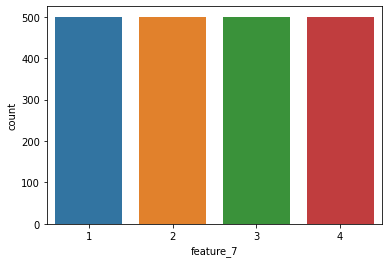

In [4]:
sns.countplot(data[target_column])

In [5]:
import math

def gini_impurity(arr):
  _,counts = np.unique(arr,return_counts=True)
  return 1 - np.sum((counts/len(arr))**2)

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test = train_test_split(data,test_size=0.2,random_state=7)

In [20]:
import scipy

class CustomDecisionTreeClassifier:

  def __init__(self,
               X,
               target_column="target",
               depth=0,
               max_depth=5):

    self.left = None
    self.center = None
    self.right = None
    self.fval = None
    self.child_nodes = 3
    self.fkey = None
    self.max_depth = max_depth
    self.target_column = target_column
    self.depth = depth
    self.data = X
    self.endpoints = None


    self.train(self.data)

  def __entropy(self,arr):
    values,counts = np.unique(arr,return_counts=True)
    probs = counts/len(arr)

    return -1*np.sum(probs*np.log2(probs))

  def __divide_data(self,df,column,fval):
    
    x_left  = df[df[column] <= fval]
    x_right = df[df[column] >  fval]

    return x_left,x_right
    
  def __information_gain(self,data,fkey,fval):
    
    left,right = self.__divide_data(data,fkey,fval)

    prob_l = float(left.shape[0]/data.shape[0])
    prob_r = float(right.shape[0]/data.shape[0])

    i_gain = self.__entropy(data[self.target_column].values) - ( 
        prob_l*self.__entropy(left[self.target_column].values) + 
        prob_r*self.__entropy(right[self.target_column].values)
        )
    
    return i_gain
  
  def train(self,data):
    features = data.columns[:-1]
    info_gains = []

    for ix in features:
      info_gains.append(self.__information_gain(data,ix,data[ix].mean()))
    
    self.fkey = features[np.argmax(info_gains)]
    self.fval = data[self.fkey].mean()
    # print(self.fkey,self.fval,info_gains)


    left,right = self.__divide_data(data,self.fkey,self.fval)
    # print(f"Key at {self.fkey} with {self.fval}")    

    if left.shape[0] == 0 or right.shape[0] == 0:
      self.target_val = int(np.ceil(data[self.target_column].mean()))
      return
    
    if self.depth >= self.max_depth :
      self.target_val = int(np.ceil(data[self.target_column].mean()))
      return
    
    self.left = CustomDecisionTreeClassifier(left,depth=self.depth+1 ,max_depth = self.max_depth,target_column=self.target_column)
    self.right = CustomDecisionTreeClassifier(right,depth=self.depth+1 ,max_depth = self.max_depth,target_column=self.target_column)
    
    self.target_val = int(np.ceil(data[self.target_column].mean()))
    return
  
  def predict(self,test):

    if test[self.fkey] <= self.fval:
      if self.left is None:
        return self.target_val
      
      return self.left.predict(test)
    
    else:
      if self.right is None:
        return self.target_val
      
      return self.right.predict(test)

In [21]:
from tqdm.notebook import tqdm
scores = []
for i in tqdm(range(3,11)):
  tree = CustomDecisionTreeClassifier(x_train,depth=1,max_depth=i,target_column=target_column)

  preds = []
  for ix in range(x_test.shape[0]):
    preds.append(tree.predict(x_test.iloc[ix]))

  from sklearn.metrics import accuracy_score
  score = accuracy_score(x_test[target_column],preds)
  scores.append(score)

Text(0, 0.5, 'Accuracy Score')

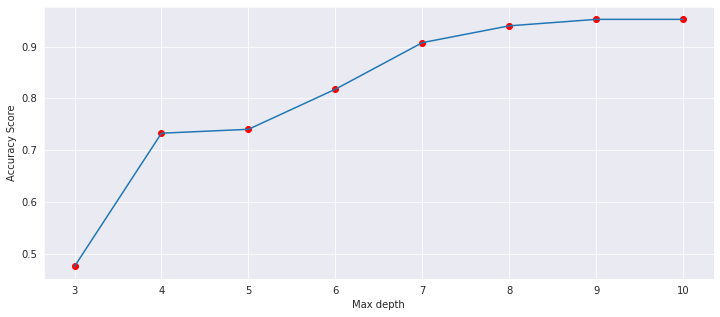

In [33]:
sns.set_style('darkgrid')

plt.figure(figsize=(12,5))
plt.scatter(range(3,11),scores,marker="o",color="red")
plt.title("Relationship Between Accuracy score and Max Depth")
plt.plot(range(3,11),scores)
plt.xlabel("Max depth")
plt.ylabel('Accuracy Score')


In [73]:
max_depth = 5
tree = CustomDecisionTreeClassifier(x_train,depth=1,max_depth=max_depth,target_column=target_column)
g=tree

def print_node(node):
  
  if node == None:
    print('ss')
    return 
  else:
    print(node.fkey)
  
  if node:
    print_node(node.right)
    print_node(node.left)



def print_level(tree , level):
  if tree == None : return
  if level is 1:
    print(tree.fkey,end=" ")
  
  print_level(tree.left,level-1)
  print_level(tree.right,level-1)

for i in range(1,max_depth+1):
  print(f"Level {i} ::: ",end=" ")
  print_level(tree,i)
  print()

Level 1 :::  feature_0 
Level 2 :::  feature_4 feature_0 
Level 3 :::  feature_0 feature_4 feature_3 feature_2 
Level 4 :::  feature_0 feature_2 feature_4 feature_0 feature_4 feature_6 feature_0 feature_2 
Level 5 :::  feature_0 feature_0 feature_6 feature_3 feature_4 feature_0 feature_0 feature_0 feature_2 feature_4 feature_1 feature_4 feature_0 feature_0 feature_0 feature_5 
